# Table of Contents

1. [Introduction](#intro)
1. [Cleaning and EDA](#s0)
    1. [Importing and cleaning data](#import)
    1. [Bar chart of glitch class counts](#barplot)
    1. [Pairplot](#pairplot)
    1. [Correlation](#corr)
1. [Image Classification](#img_class)
    1. [Multinomial logistical regression](logit)
    1. [Deep neural networks]()
    1. [Convolution neural networks]()
    1. [Results]()

# Final Project: Determining glitch morphology classification
## DATS 6202 - Machine Learning I 
### Izzy Illari (gwid) and Lucia Illari (gwid)

# Introduction
<a id = "intro"></a>

<div align="left"> <font size="3"><i>Fig. 1:</i> The gravitational-wave event GW150914 observed by the LIGO Hanford (H1, left column panels) and Livingston (L1, right
column panels) detectors, with times shown relative to September 14, 2015 at 09:50:45 UTC. These are the time-frequency representation of the
strain data, demonstrating the "chirp" or frequency shift across time. (<a href="https://physics.aps.org/featured-article-pdf/10.1103/PhysRevLett.116.061102">image source</a>) </font></div>

<img style="display: block; margin-left: 50px; margin-right: 50px" src="gw150914_chirp.png" align="center" width="1000">

**TO DO:**

- [X] add table of contents
- [ ] write information between code cells and topics
    - [X] title
    - [ ] intro
        - [ ] about the dataset
        - [ ] problem 
        - [ ] motivation
    - [ ] experiment
        - [ ] code
        - [ ] discussion of results
    - [ ] conclusions
    
**for basic eda:**
    
- [X] import data
    - [X] select certain columns
    - [X] check if there is any missing data
    - [X] split data into test/train/val datasets
    - [ ] use dummies function to encode categorical features (just ifo I think?)
    - [ ] split features and target
- [X] counts of glitch classes & bar chart
- [X] corner plot
- [X] correlation
- [ ] set the data up at the end of this section so it is EXACTLY the features you want and nothing more
- [ ] scale the data

**DO THESE FOR IMAGE CLASSIFICATION:**

- [ ] Logistic reg/multinomial logit reg/softmax
- [ ] Random forests
- [ ] ANN
- [ ] CNN
- [ ] KNN
- [ ] Decision tree
- [ ] SVM

**PREVIOUS IDEAS, PROBABLY SCRAPPED?**

**for metadata?:**

- [ ] LogisticRegression
- [ ] MLPClassifier
- [ ] HistGradientBoostingClassifier
- [ ] DecisionTreeClassifier
- [ ] SVM

**for images:**

- [ ] DNN
- [ ] CNN

# Cleaning and EDA
<a id = "s0"></a>

## Importing and cleaning the data
<a id = "import"></a>

In [1]:
#importing necessary packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
# kaggle api
import kaggle
# find OS
import platform
pform = platform.system().lower()

#for setting the seed
random_seed = 1234

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#get current directory
directory = os.getcwd()

# check if OS is mac
if pform == 'darwin':
    print("OS is " + str(platform.system()))
    # check that data doesn't already exist
    if not os.path.isfile(directory + "/gravity-spy-gravitational-waves.zip"):
        print("File does not exist! Downloading...")
        # import data from Kaggle API
        # this downloads to current directory
        !kaggle datasets download -d tentotheminus9/gravity-spy-gravitational-waves
    elif os.path.isfile(directory + "/gravity-spy-gravitational-waves.zip"):
        print("File exists!")

# check if OS is windows
elif pform in ['windows','cygwin']:
    print("OS is " + str(platform.system()))
    # check that data doesn't already exist
    if not os.path.isfile(directory + "\\gravity-spy-gravitational-waves.zip"):
        print("File does not exist! Downloading...")
        # import data from Kaggle API
        # this downloads to current directory
        !kaggle datasets download -d tentotheminus9/gravity-spy-gravitational-waves
    elif os.path.isfile(directory + "\\gravity-spy-gravitational-waves.zip"):
        print("File exists!")

OS is Windows
File exists!


In [3]:
%%capture
if pform == 'darwin':
    # check if data directories exist
    if not ( os.path.exists(directory + "/test/") 
            and os.path.exists(directory + "/train/") 
            and os.path.exists(directory + "/validation/") 
            and os.path.isfile(directory + "/trainingset_v1d1_metadata.csv") ):
        #unzip data
        !unzip "gravity-spy-gravitational-waves.zip"

elif pform in ['windows','cygwin']:
    # check if data directories exist
    if not ( os.path.exists(directory + "\\test") 
            and os.path.exists(directory + "\\train") 
            and os.path.exists(directory + "\\validation") 
            and os.path.isfile(directory + "\\trainingset_v1d1_metadata.csv") ):
        #unzip data
        !unzip "gravity-spy-gravitational-waves.zip"

In [4]:
#get image data directories
if pform == 'darwin':
    train_dir = directory + '/train/train/'
    test_dir = directory + '/test/test/'
    validation_dir = directory + '/validation/validation/'

elif pform in ['windows','cygwin']:
    train_dir = directory + '\\train\\train\\'
    test_dir = directory + '\\test\\test\\'
    validation_dir = directory + '\\validation\\validation\\'

In [6]:
#get image metadata
if pform in ['windows','cygwin']:
    meta_original = pd.read_csv(directory+'\\trainingset_v1d1_metadata.csv')
elif pform == 'darwin':
    meta_original = pd.read_csv(directory+'/trainingset_v1d1_metadata.csv')

#set target for classification
target = 'label'

In [7]:
#check if any missing data
meta_original.replace('', np.nan, inplace=True)
print("There are",meta_original.isnull().sum().sum(),"NaN elements in the metadata.")

There are 0 NaN elements in the metadata.


In [8]:
#get the counts for the glitch classes
label_counts = pd.DataFrame(meta_original['label'].value_counts())
label_counts.reset_index(level=0, inplace=True)
label_counts = label_counts.rename(columns={"index": "class", "label": "counts"})
label_counts['percent'] = label_counts['counts']/label_counts['counts'].sum()*100

In [9]:
#get all glitch classes
categories = list(label_counts['class'])

#view columns
meta_original.columns

Index(['event_time', 'ifo', 'peak_time', 'peak_time_ns', 'start_time',
       'start_time_ns', 'duration', 'search', 'process_id', 'event_id',
       'peak_frequency', 'central_freq', 'bandwidth', 'channel', 'amplitude',
       'snr', 'confidence', 'chisq', 'chisq_dof', 'param_one_name',
       'param_one_value', 'gravityspy_id', 'label', 'sample_type', 'url1',
       'url2', 'url3', 'url4'],
      dtype='object')

In [10]:
#most of the columns are unnecessary for our purposes, so we will drop them
meta = meta_original[['duration','ifo','peak_frequency','central_freq','bandwidth','amplitude','snr','param_one_value','label','sample_type']]
meta = meta.rename(columns={"param_one_value": "phase"})

#subset metadata into train, test, and validation datasets
meta_train = meta[meta["sample_type"] == 'train']
meta_train.drop('sample_type', axis=1, inplace=True)

meta_test = meta[meta["sample_type"] == 'test']
meta_test.drop('sample_type', axis=1, inplace=True)

meta_val = meta[meta["sample_type"] == 'validation']
meta_val.drop('sample_type', axis=1, inplace=True)

In [11]:
#quick look at data
meta_val

,duration,ifo,peak_frequency,central_freq,bandwidth,amplitude,snr,phase,label
3,0.82422,L1,1182.974609,3981.774658,7492.717773,1.462120e-22,10.321160,0.76242,Whistle
4,2.00366,L1,1456.511353,3979.026855,7942.912109,4.038300e-22,14.380160,-0.31161,Whistle
6,0.70312,L1,823.183594,2520.089111,4840.522949,9.513880e-23,9.273810,0.50844,Whistle
11,0.09375,L1,326.978760,325.483459,23.179831,5.591810e-22,7.765430,-0.26669,Whistle
13,0.30078,L1,1834.615723,3610.706787,6973.997559,1.835290e-22,8.530150,-1.12437,Whistle
...,...,...,...,...,...,...,...,...,...
7931,0.51758,H1,123.754059,138.069626,130.556854,6.967370e-23,8.591070,2.52188,Scratchy
7938,0.44531,H1,1085.830078,4298.645996,6898.204590,2.366700e-22,8.427400,-0.59947,1080Lines
7946,0.04688,L1,134.965424,206.664536,178.921906,5.645310e-22,9.388550,2.19965,Helix
7955,0.81250,L1,121.663269,444.386383,824.772766,9.080070e-22,82.451103,0.06565,Koi_Fish


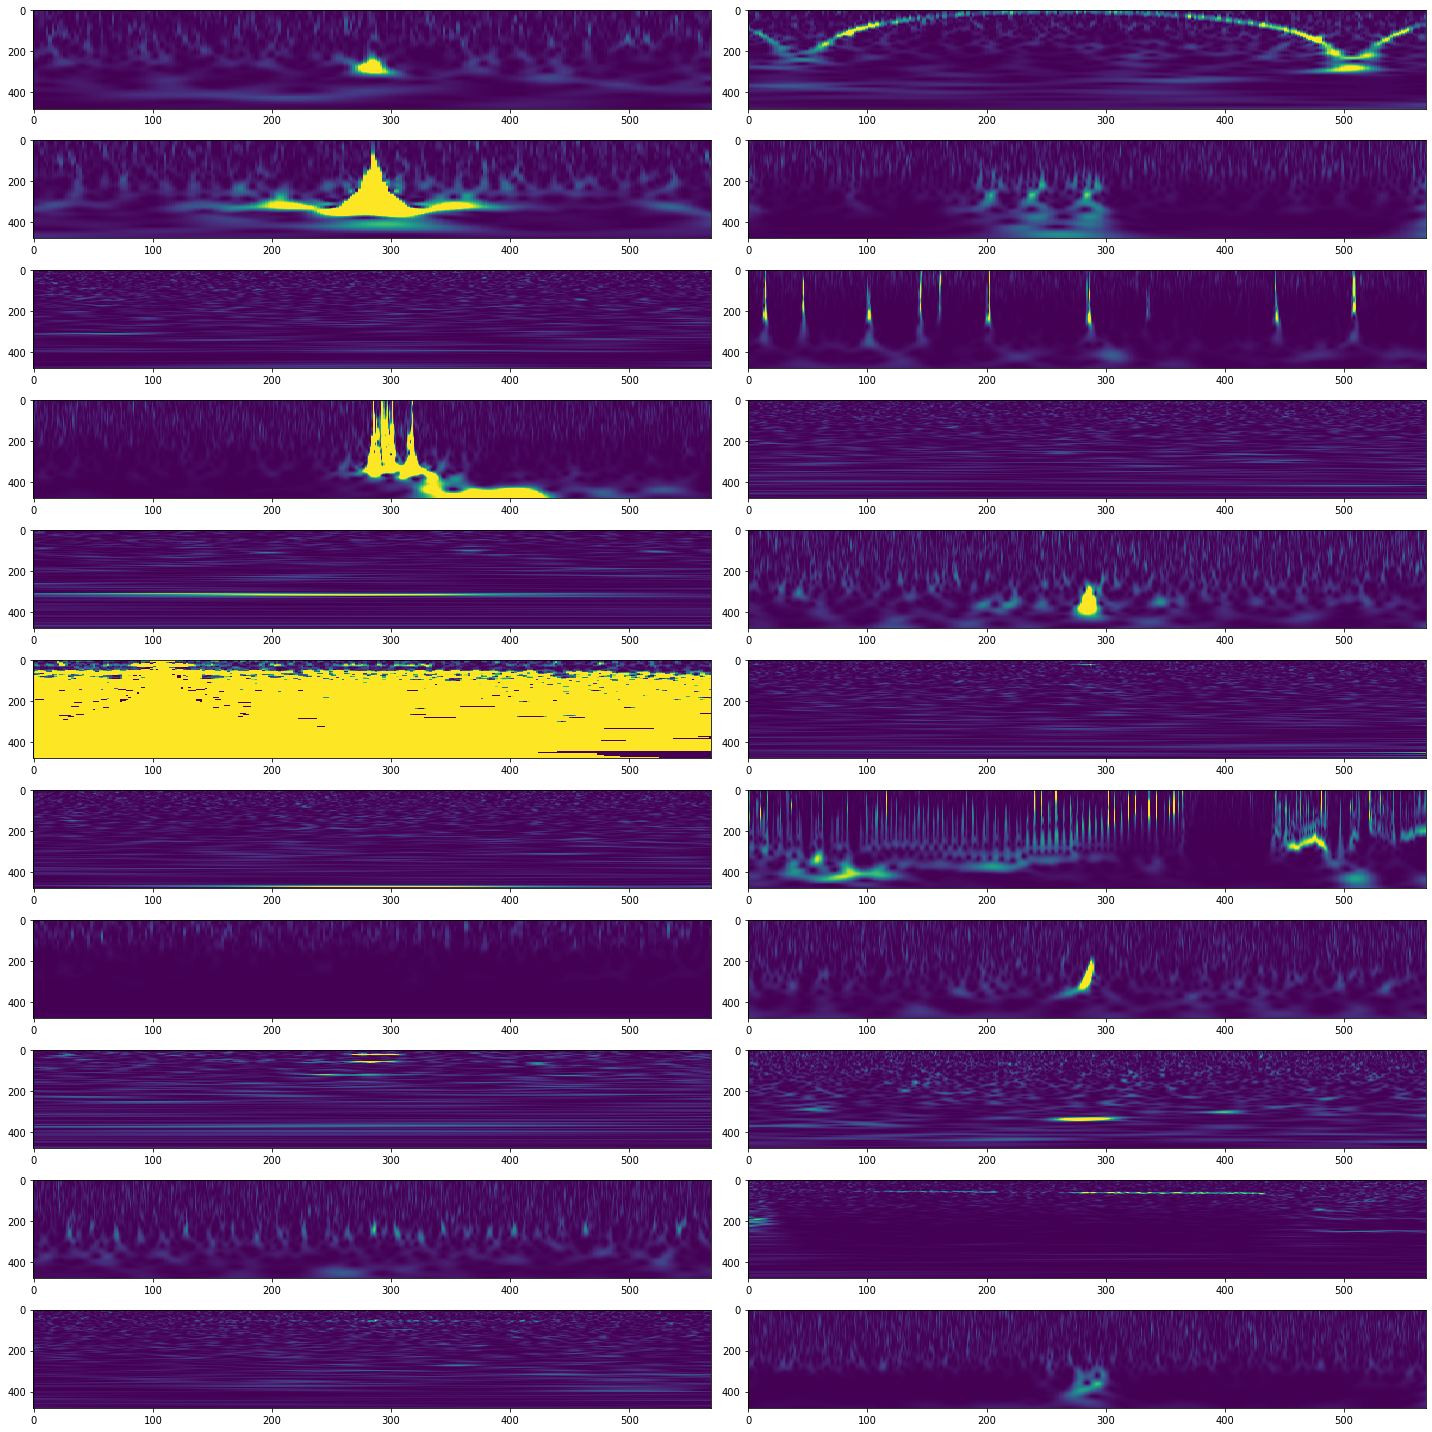

In [12]:
#let's look at one plot for each glitch class
counter = 0
fig, ax = plt.subplots(11, 2, figsize=(20, 20))

for k in range(2):
    for j in range(11):
        #get location folder of glitch class
        loc = train_dir + categories[counter]
        fold_loc = os.listdir(loc)
        #get image in folder
        if pform in ['windows','cygwin']:
            to_show = img.imread(loc + "\\" + fold_loc[round(len(fold_loc)/2)])
        elif pform == "darwin":
            to_show = img.imread(loc + "/" + fold_loc[round(len(fold_loc)/2)])
        ax[j,k].imshow(to_show, aspect='auto')
        counter = counter + 1
        if counter == len(categories):
            break
    else:
        #only executed if the inner loop didn't break
        continue 
    #only executed if the inner loop did break
    break
plt.tight_layout()
plt.show()

## Bar chart of glitch class counts
<a id = 'barplot'></a>

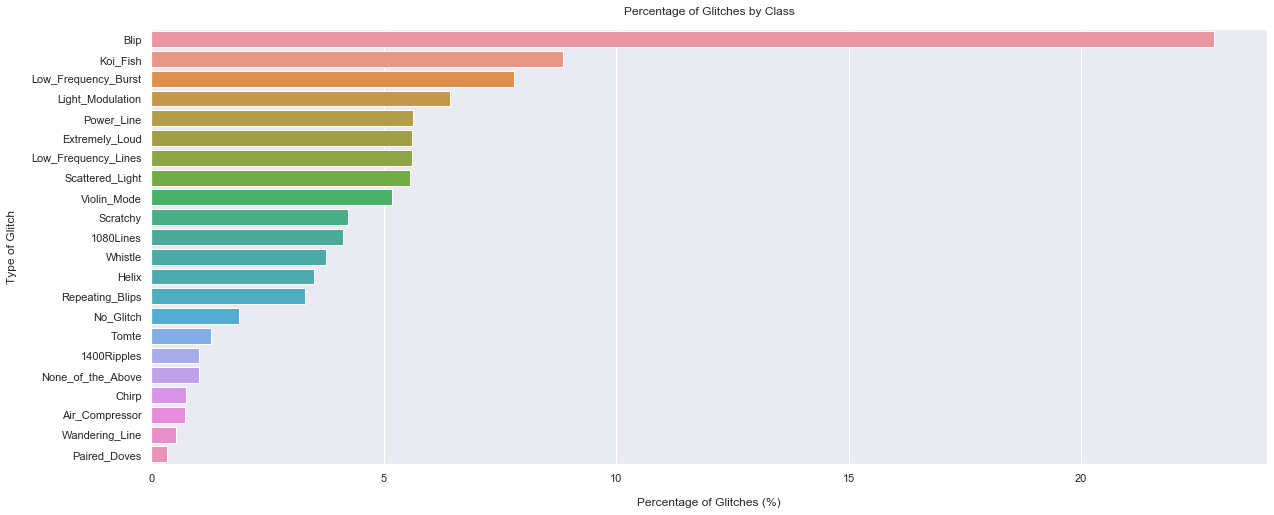

In [13]:
#setting plot size
sns.set(rc={'figure.figsize':(20,8)})

#let's look at how many glitch classes and how many of each kind there are
b1 = sns.barplot(x="percent", y="class", data=label_counts, orient = "h");
b1.set_ylabel("Type of Glitch", labelpad=14);
b1.set_xlabel("Percentage of Glitches (%)", labelpad=14)
b1.set_title("Percentage of Glitches by Class", y=1.02);

## Pairplot
<a id = 'pairplot'></a>

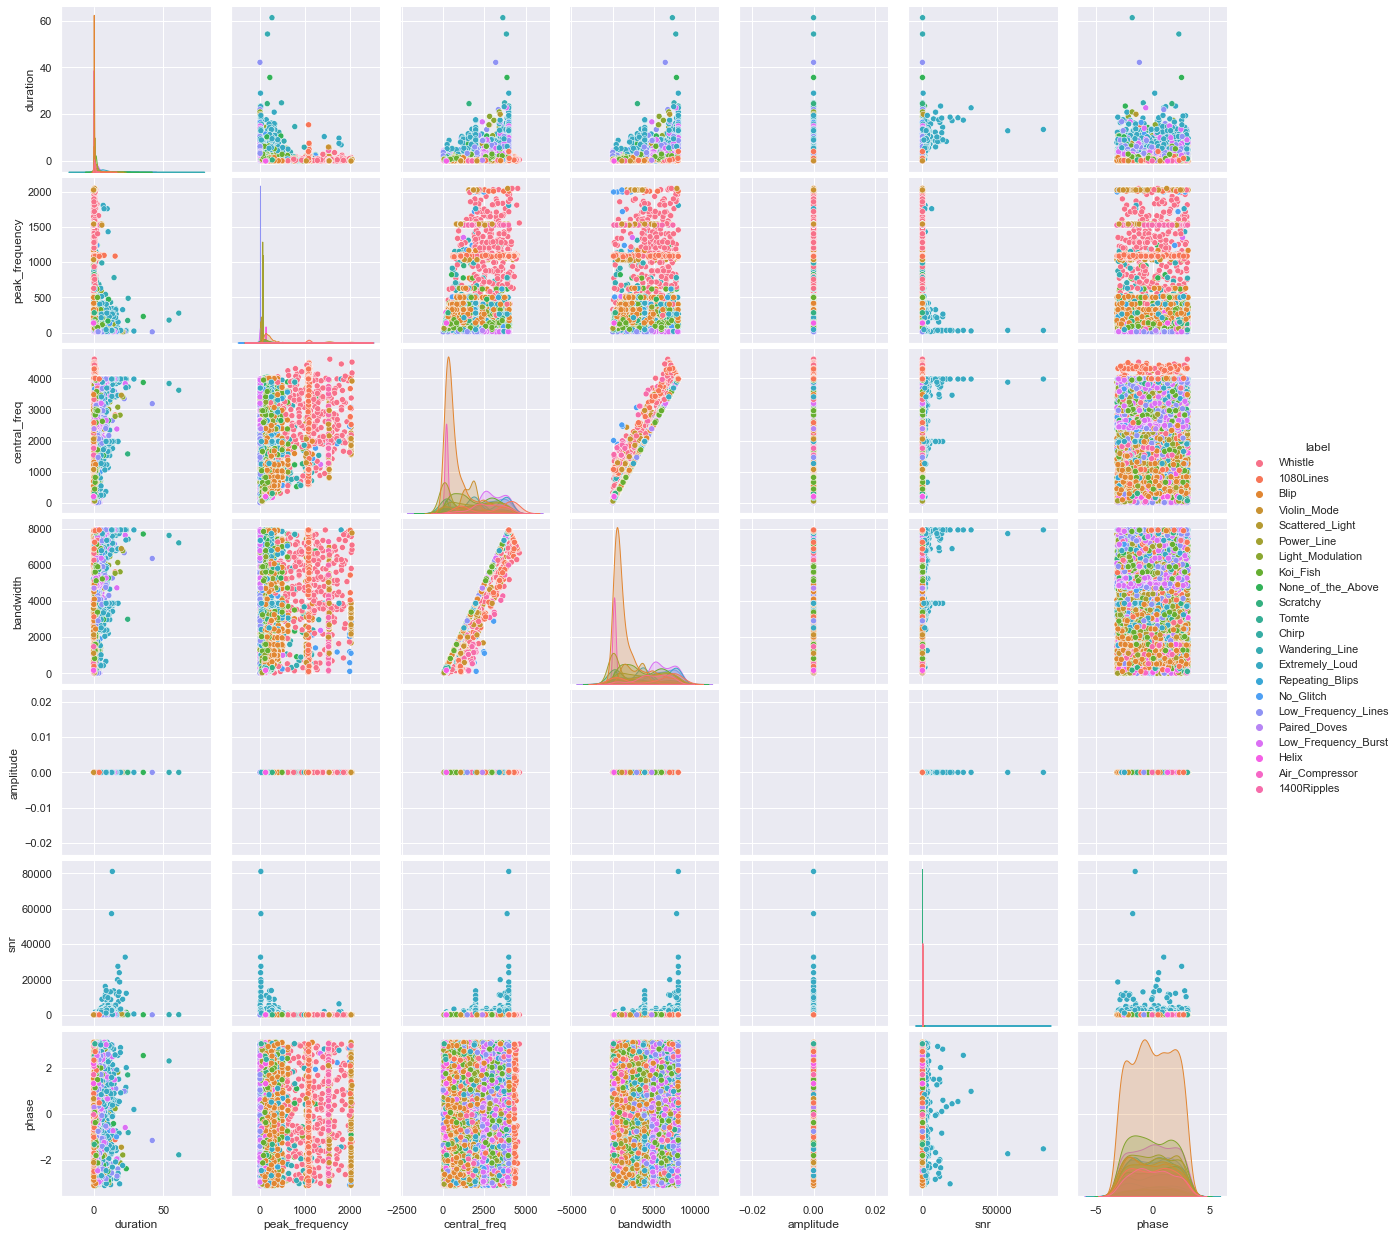

In [14]:
sns.pairplot(meta, hue="label");

## Correlation
<a id = "corr"></a>

In [15]:
#integer encode the categorical columns
meta['label_int'] = meta.label.astype('category').cat.codes
meta['ifo_int'] = meta.ifo.astype('category').cat.codes

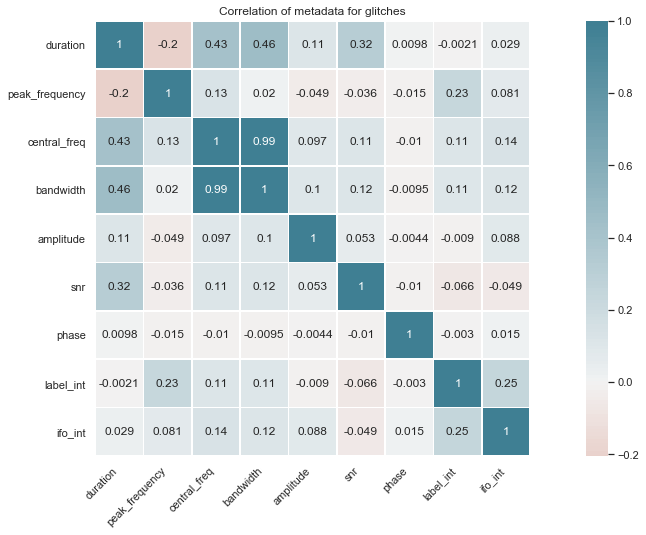

In [16]:
corr = meta.corr(method='pearson')

hm1 = sns.heatmap(corr,center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True, annot=True, linewidths=.5)
hm1.set_xticklabels(hm1.get_xticklabels(),rotation=45,horizontalalignment='right');
#strange cut-oof of top and bottom rows that requires manually setting the y-axis
hm1.set_ylim(9, 0);
hm1.set_title("Correlation of metadata for glitches");

# Image classification
<a id = "img_class"></a>

## Multinomial logistical regression
<a id = "logit"></a>